In [1]:
import pandas as pd 
import numpy as np
from scipy import linalg
from scipy.spatial.distance import pdist
import networkx as nx
import sys
import random

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from sklearn.metrics import DistanceMetric
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import adjusted_rand_score

import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from matplotlib import rcParams, cycler

In [2]:
def norm_and_pca_from_df(df):
    '''
    Function processes the data using Principal component analysis(PCA)
    Args:
        df : Dataframe 
    Returns normalized dataframe and principal component of df
    '''
    
    df_normalized = pd.DataFrame()
    cols = list(df.columns)
    df_normalized[cols] = pd.DataFrame(normalize(MinMaxScaler().fit_transform(df[cols])))
    df_normalized.index = df.index
    
    df_pca = pd.DataFrame(PCA(n_components = 2).fit_transform(df_normalized))
    df_pca.columns = ['P1', 'P2']
    df_pca.index = df.index
    
    return df_normalized, df_pca

In [3]:
# Load and transform dataset 0
df_csv = pd.read_csv("test.csv")
index_labels = df_csv["points"]
class_labels = df_csv["class"]
df_data = df_csv[["x_coordinate","y_coordinate"]]

df_normalized = df_csv.copy()
df_pca = df_csv.copy()

df_normalized[["x_coordinate","y_coordinate"]], df_pca[["x_coordinate","y_coordinate"]] = norm_and_pca_from_df(df_data)

In [4]:
df_csv

,points,x_coordinate,y_coordinate,class
0,p1,1,7,1
1,p2,1,6,1
2,p3,6,2,2
3,p4,8,1,2
4,p5,10,2,2


In [5]:
df_data

,x_coordinate,y_coordinate
0,1,7
1,1,6
2,6,2
3,8,1
4,10,2


### Abhivanth --start--

In [6]:
# Pairwise distances
dimension = df_data.shape[0]
dist_ = pdist(df_data)
pdist = np.zeros([dimension, dimension])
dist = iter(dist_)
for i in range(dimension):
    for j in range(i+1, dimension):  
        d = next(dist)
        pdist[i,j] = d
        pdist[j,i] = d

In [7]:
pdist

array([[ 0.        ,  1.        ,  7.07106781,  9.21954446, 10.29563014],
       [ 1.        ,  0.        ,  6.40312424,  8.60232527,  9.8488578 ],
       [ 7.07106781,  6.40312424,  0.        ,  2.23606798,  4.        ],
       [ 9.21954446,  8.60232527,  2.23606798,  0.        ,  2.23606798],
       [10.29563014,  9.8488578 ,  4.        ,  2.23606798,  0.        ]])

In [8]:
#calculate local sigma
sigmas = np.zeros(dimension)
for i in tqdm(range(len(pdist))):
    sigmas[i] = sorted(pdist[i])[2]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


In [9]:
sigmas

array([7.07106781, 6.40312424, 4.        , 2.23606798, 4.        ])

In [10]:
# Adjaceny matrix with optimal sigma
adjacency_matrix = np.zeros([dimension, dimension])
dist = iter(dist_)
for i in tqdm(range(dimension)):
    for j in range(i+1, dimension):  
        d = np.exp(-1*next(dist)**2/(sigmas[i]*sigmas[j]))
        adjacency_matrix[i,j] = d
        adjacency_matrix[j,i] = d

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


In [11]:
adjacency_matrix

array([[0.        , 0.97815581, 0.17071378, 0.00462688, 0.0235727 ],
       [0.97815581, 0.        , 0.20173889, 0.00569376, 0.02265865],
       [0.17071378, 0.20173889, 0.        , 0.57177084, 0.36787944],
       [0.00462688, 0.00569376, 0.57177084, 0.        , 0.57177084],
       [0.0235727 , 0.02265865, 0.36787944, 0.57177084, 0.        ]])

### Abhivanth --end--

### Evelina --start--

In [12]:
# Calculate degree matrix
degree_matrix = np.sum(adjacency_matrix, axis=0) * np.eye(dimension)

In [13]:
degree_matrix

array([[1.17706917, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.20824711, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.31210294, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.15386233, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.98588163]])

In [14]:
# Normalized laplacian matrix
d_half = linalg.fractional_matrix_power(degree_matrix, -0.5)
laplacian_matrix_normalized = np.matmul(np.matmul(d_half, adjacency_matrix), d_half)

In [15]:
laplacian_matrix_normalized

array([[0.        , 0.82021775, 0.13736738, 0.00397018, 0.02188245],
       [0.82021775, 0.        , 0.16022408, 0.00482219, 0.02076078],
       [0.13736738, 0.16022408, 0.        , 0.46468757, 0.3234515 ],
       [0.00397018, 0.00482219, 0.46468757, 0.        , 0.53608372],
       [0.02188245, 0.02076078, 0.3234515 , 0.53608372, 0.        ]])

In [25]:
# Calculating eigenvalues and eigenvectors no. of clusters k

k = 2

e, v = np.linalg.eigh(laplacian_matrix_normalized)
X = v[:, -1*k:]
# row_sums = X.sum(axis=1)
# Y = X / row_sums[:, np.newaxis]

In [28]:
e

array([-0.8206952 , -0.57523313, -0.33568559,  0.73161392,  1.        ])

In [26]:
v

array([[ 0.70409004, -0.0566426 , -0.10601376,  0.53680445,  0.44905556],
       [-0.70933903, -0.02912576, -0.06842028,  0.5332132 ,  0.45496393],
       [ 0.02986362,  0.34956086,  0.76882447, -0.24706263,  0.47411428],
       [-0.01380967, -0.7723868 , -0.06657522, -0.44846458,  0.44460678],
       [-0.00357876,  0.52646855, -0.62334294, -0.40665003,  0.41097128]])

In [27]:
X

array([[ 0.53680445,  0.44905556],
       [ 0.5332132 ,  0.45496393],
       [-0.24706263,  0.47411428],
       [-0.44846458,  0.44460678],
       [-0.40665003,  0.41097128]])

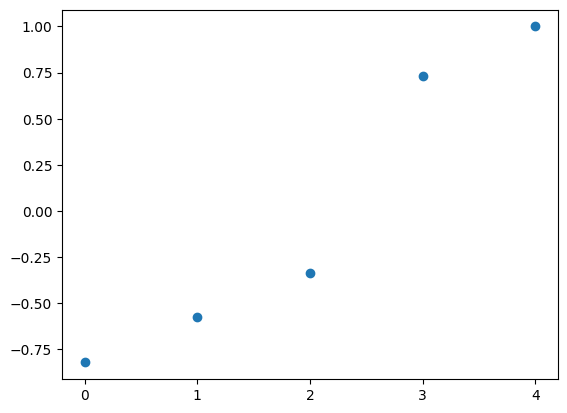

In [37]:
plt.scatter(range(len(e)), e);
plt.xticks(range(0,len(e)));

### Evelina --end--